In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd

# How to build a GeoDataFrame

- See https://gist.github.com/sgillies/2217756 for the "`__geo_interface__`".
- But this basically copies GeoJSON, for which see https://tools.ietf.org/html/rfc7946

It's then as simple as this...

In [22]:
features = [{#"type": "Feature",
           "geometry": {
               "type": "Point",
               "coordinates": [102.0, 0.5]
           },
           "properties": {
               "prop0": "value0", "prop1": "value1"
           }
       }]

data = gpd.GeoDataFrame.from_features(features)
data

,geometry,prop0,prop1
0,POINT (102 0.5),value0,value1


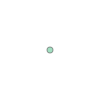

In [14]:
data.ix[0].geometry

In [23]:
features = [{#"type": "Feature",
           "geometry": {
               "type": "LineString",
               "coordinates": [[102.0, 0.5], [104, 3], [103, 2]]
           },
           "properties": {
               "prop0": "value0"
           }
       }]

data = gpd.GeoDataFrame.from_features(features)
data

,geometry,prop0
0,"LINESTRING (102 0.5, 104 3, 103 2)",value0


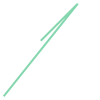

In [18]:
data.ix[0].geometry

In [24]:
features = [{#"type": "Feature",
           "geometry": {
               "type": "Polygon",
               "coordinates": [[[102.0, 0.5], [104, 3], [102, 2], [102,0.5]]]
           },
           "properties": {
               "prop0": "value0", "prop1": "value1"
           }
       }]

data = gpd.GeoDataFrame.from_features(features)
data

,geometry,prop0,prop1
0,"POLYGON ((102 0.5, 104 3, 102 2, 102 0.5))",value0,value1


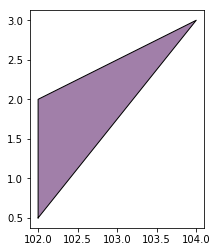

In [20]:
data.plot()

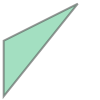

In [21]:
data.ix[0].geometry

## Notes

Some things that jumped out at me as I read the GeoJSON spec:

- A "Polygon" is allowed to contain holes.  The "outer" edge should be ordered counter-clockwise, and each "inner" edge (i.e. a "hole") should be clockwise.
- If a polygon contains more than one array of points, then the first array is the outer edge, and the rest inner edges.
- Lines crossing the anti-meridian need to be split.  (I wonder what OSM does?)

# Worked example

Extract all buildings from the Illinois data.

We assume the notebook "Pythonify" has been run, so that the files `illinois_nodes_packed.pic.xz` etc. are present.

In [2]:
# Allow to import without installing
import sys
sys.path.insert(0, "..")

In [3]:
import osmdigest.pythonify as pythonify

In [4]:
ways = pythonify.unpickle("illinois_ways.pic.xz")
tags = pythonify.unpickle("illinois_tags.pic.xz")

In [7]:
# Check!!
"osm_id" in tags.all_way_tag_keys

False

In [8]:
# Lots and lots of values!!
set( value for value, _ in tags.ways_from_key("building") )

{'Chicago Biology and  Medicine',
 'Commercial',
 'Community_Center',
 'Condominium',
 'Department_Building',
 'Faraday Hall',
 'Fort',
 'Gazebo',
 'Gym',
 'Lucky Dog',
 'Mausoleum',
 'Office_Space',
 'R3 Environmental',
 'Rec_Center',
 'Residential,_business,_restaurants',
 'YMCA',
 'Yoga_Studio',
 'amphitheatre',
 'apartments',
 'barn',
 'barn;garage',
 'barracks',
 'boathouse',
 'brewery',
 'bunker',
 'cabin',
 'canopy',
 'carport',
 'central_office',
 'chapel',
 'church',
 'cinema',
 'civic',
 'collapsed',
 'college',
 'commercial',
 'commercial;office',
 'commercial;roof',
 'condominium',
 'construction',
 'convent',
 'corridor',
 'demolished',
 'detached',
 'dormitory',
 'entrance',
 'exterior_walls_only',
 'factory',
 'farm',
 'farm_auxiliary',
 'field_house',
 'flats',
 'foundation',
 'garage',
 'garage;house',
 'garage;shed',
 'garages',
 'gazebo',
 'glasshouse',
 'grandstand',
 'greenhouse',
 'hangar',
 'historic',
 'hospital',
 'hotel',
 'house',
 'hut',
 'industrial',
 'ins

In [9]:
building_ids = [ osm_id for _, osm_id in tags.ways_from_key("building") ]
len(building_ids)

1063568

In [10]:
nodes = pythonify.unpickle("illinois_nodes_packed.pic.xz")

In [11]:
tags_by_id = pythonify.TagsById(tags)

In [12]:
features = []
for osm_id in building_ids:
    feature = {"properties": {"osm_id" : osm_id}}
    feature["geometry"] = {"type": "Polygon", "coordinates": []}
    feature["geometry"]["coordinates"] = [[ list(nodes[node_id]) for node_id in ways[osm_id] ]]
    for key, value in tags_by_id.way(osm_id).items():
        feature["properties"][key] = value
    features.append(feature)

In [13]:
features[0]

{'geometry': {'coordinates': [[[-88.0083629, 41.7932179],
    [-88.0083166, 41.7926956],
    [-88.0084497, 41.7926899],
    [-88.0093472, 41.7926511],
    [-88.0093877, 41.7931661],
    [-88.0089168, 41.7931893],
    [-88.0083629, 41.7932179]]],
  'type': 'Polygon'},
 'properties': {'amenity': 'parking',
  'building': 'yes',
  'osm_id': 4374907,
  'parking': 'multi-storey'}}

Of course, the data would end up being noisy!!  Checking these two way ids out on openstreetmap.org shows that they are indeed composed of just 2 points.

We'll ignore them, as geopanadas cannot cope.

In [14]:
odd = []
for i, feat in enumerate(features):
    if len(feat["geometry"]["coordinates"][0]) <= 2:
        print("Odd geometry for {}".format(feat["properties"]["osm_id"]))
        odd.append(i)

for i, index in enumerate(odd):
    del features[index - i]

Odd geometry for 144710191
Odd geometry for 394123882


In [15]:
gdf = gpd.GeoDataFrame.from_features(features)

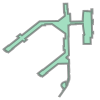

In [16]:
gdf.ix[2].geometry

In [17]:
gdf = gdf.set_index("osm_id")

In [18]:
gdf.to_file("test")

KeyboardInterrupt: 